In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
import diffrax

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import (
    AlternatingActiveSetLMSolver,
    LMSettings,
    AnnealedAlternatingActiveSetLMSolver,
)
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from jsindy.util import get_collocation_points_weights

from pysindy import STLSQ
from tqdm.auto import tqdm

# Configure
jax.config.update("jax_enable_x64", True)
plt.style.use("ggplot")
plt.rcParams['font.family'] = 'serif'
from jax.random import PRNGKey
annealing = False


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
# Random key
seed = 1234
rkey = PRNGKey(seed=seed)

In [3]:
dt = 0.005
noise = 0.01
noise_std = 0.1
dt_train = 2

n_colloc = 500

# x0 = -3.20767361e-02       # initial displacement
x0 = -0.2
dx0 = 0.0
# dx0 = 1.28199828e-03      # initial velocity

t0 = 0.0
t1 = 100.0
initial_state = jnp.array([x0, dx0])

args = (0.5,)

# def ode_sys(t, state, args):
#     x, dx = state
#     dxdt = dx
#     dydt = -1*jnp.sin(x)
#     return jnp.array([dxdt,dydt])

def ode_sys(t,state, args):
    mu = args[0]
    x, dx = state
    dxdt = dx
    dydt = mu*(1-x**2)*dx-x
    return jnp.array([dxdt,dydt])

term = diffrax.ODETerm(ode_sys)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,  # Initial step size
    y0=initial_state,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [4]:
t_true = jnp.arange(t0,t1,dt)
X_true = jax.vmap(sol.evaluate)(t_true)

t_train = jnp.arange(t0,t1, dt_train)
# extra_t_train= jnp.linspace(0,5,5)[1:]
# t_train = jnp.hstack([t_train,extra_t_train])
# t_as = jnp.argsort(t_train)
# t_train = t_train[t_as]


X_train_true = jax.vmap(sol.evaluate)(t_train)

# X_train_true = jnp.vstack(
#     [
#         X_train_true,
#         jax.vmap(sol.evaluate)(extra_t_train)
#     ]
# )[t_as]

X_train = X_train_true + noise_std*jax.random.normal(rkey,X_train_true.shape)

t_colloc, w_colloc = get_collocation_points_weights(t_train, n_colloc,bleedout_nodes=10)

In [5]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel,derivative_orders=(0,1,2))
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
sparsifier = pySindySparsifier(STLSQ(threshold = 0.1,alpha = 0.01))

if not annealing:
    optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
    )
else:
    optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e4,
        fixed_data_weight=1,
        sparsifier = sparsifier,
        num_annealing_steps=4,
    )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

In [6]:
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)
model.print()

{'show_progress': True, 'sigma2_est': Array(1.00016148e-06, dtype=float64), 'data_weight': 1, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 38.28, gradnorm = 2.226e+04, alpha = 4.167, improvement_ratio = 0.9823
Iteration 1, loss = 1.082, gradnorm = 2.659e+03, alpha = 3.472, improvement_ratio = 0.9868
Iteration 2, loss = 0.5541, gradnorm = 792.0, alpha = 2.894, improvement_ratio = 0.9215
Iteration 3, loss = 0.4995, gradnorm = 333.6, alpha = 2.894, improvement_ratio = 0.6577
Iteration 4, loss = 0.4603, gradnorm = 270.9, alpha = 2.411, improvement_ratio = 0.825
Iteration 5, loss = 0.4448, gradnorm = 144.4, alpha = 2.411, improvement_ratio = 0.7929
Iteration 64, loss = 0.3377, gradnorm = 5.945e-09, alpha = 0.0001597, improvement_ratio = 2.23e+03
Model after smooth warm start
(x)'' = -0.006 1 + -0.984 x + 0.532 (x') + 0.015 x^2 + 0.068 x (x') + -0.012 (x')^2 + 0.001 x^3 + -0.305 x^2 (x') + 0.023 x (x')^2 + -0.076 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized
(x)'' = -0.982 x + 0.343 (x') + -0.337 x^2 (x')


In [11]:
model.print(precision=5)

(x)'' = -0.98187 x + 0.34252 (x') + -0.33674 x^2 (x')


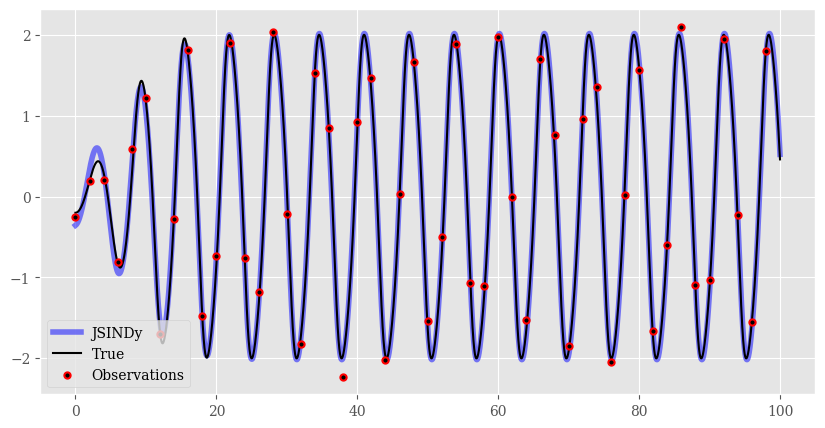

In [12]:
x_pred = model.predict_state(t_true)

plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=20,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [13]:
rel_noise = noise_std/jnp.std(X_true[:,0])

rel_noise.item(), noise_std

(0.07388351357232255, 0.1)

In [14]:
def model_state_pred(t,state,args):
    x, dx = state
    dxdt = dx
    return jnp.array([dxdt,model.predict(jnp.array(state))[0]])

model_term = diffrax.ODETerm(model_state_pred)

new_start = t1 - 0.01
# new_start = t1
new_init = sol.evaluate(new_start)
sol_continue = diffrax.diffeqsolve(
    term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

simulated_sol = diffrax.diffeqsolve(
    model_term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [15]:
new_grid = jnp.linspace(new_start,2*t1,500)
# plt.plot(new_grid,jax.vmap(sol_continue.evaluate)(new_grid)[:,0])
# plt.plot(new_grid,jax.vmap(simulated_sol.evaluate)(new_grid)[:,0])

# plt.show()

true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:,0]
learned_forward = jax.vmap(simulated_sol.evaluate)(new_grid)[:,0]

dx_true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:,1]
dx_learned_forward = jax.vmap(simulated_sol.evaluate)(new_grid)[:,1]
cutoff =-1

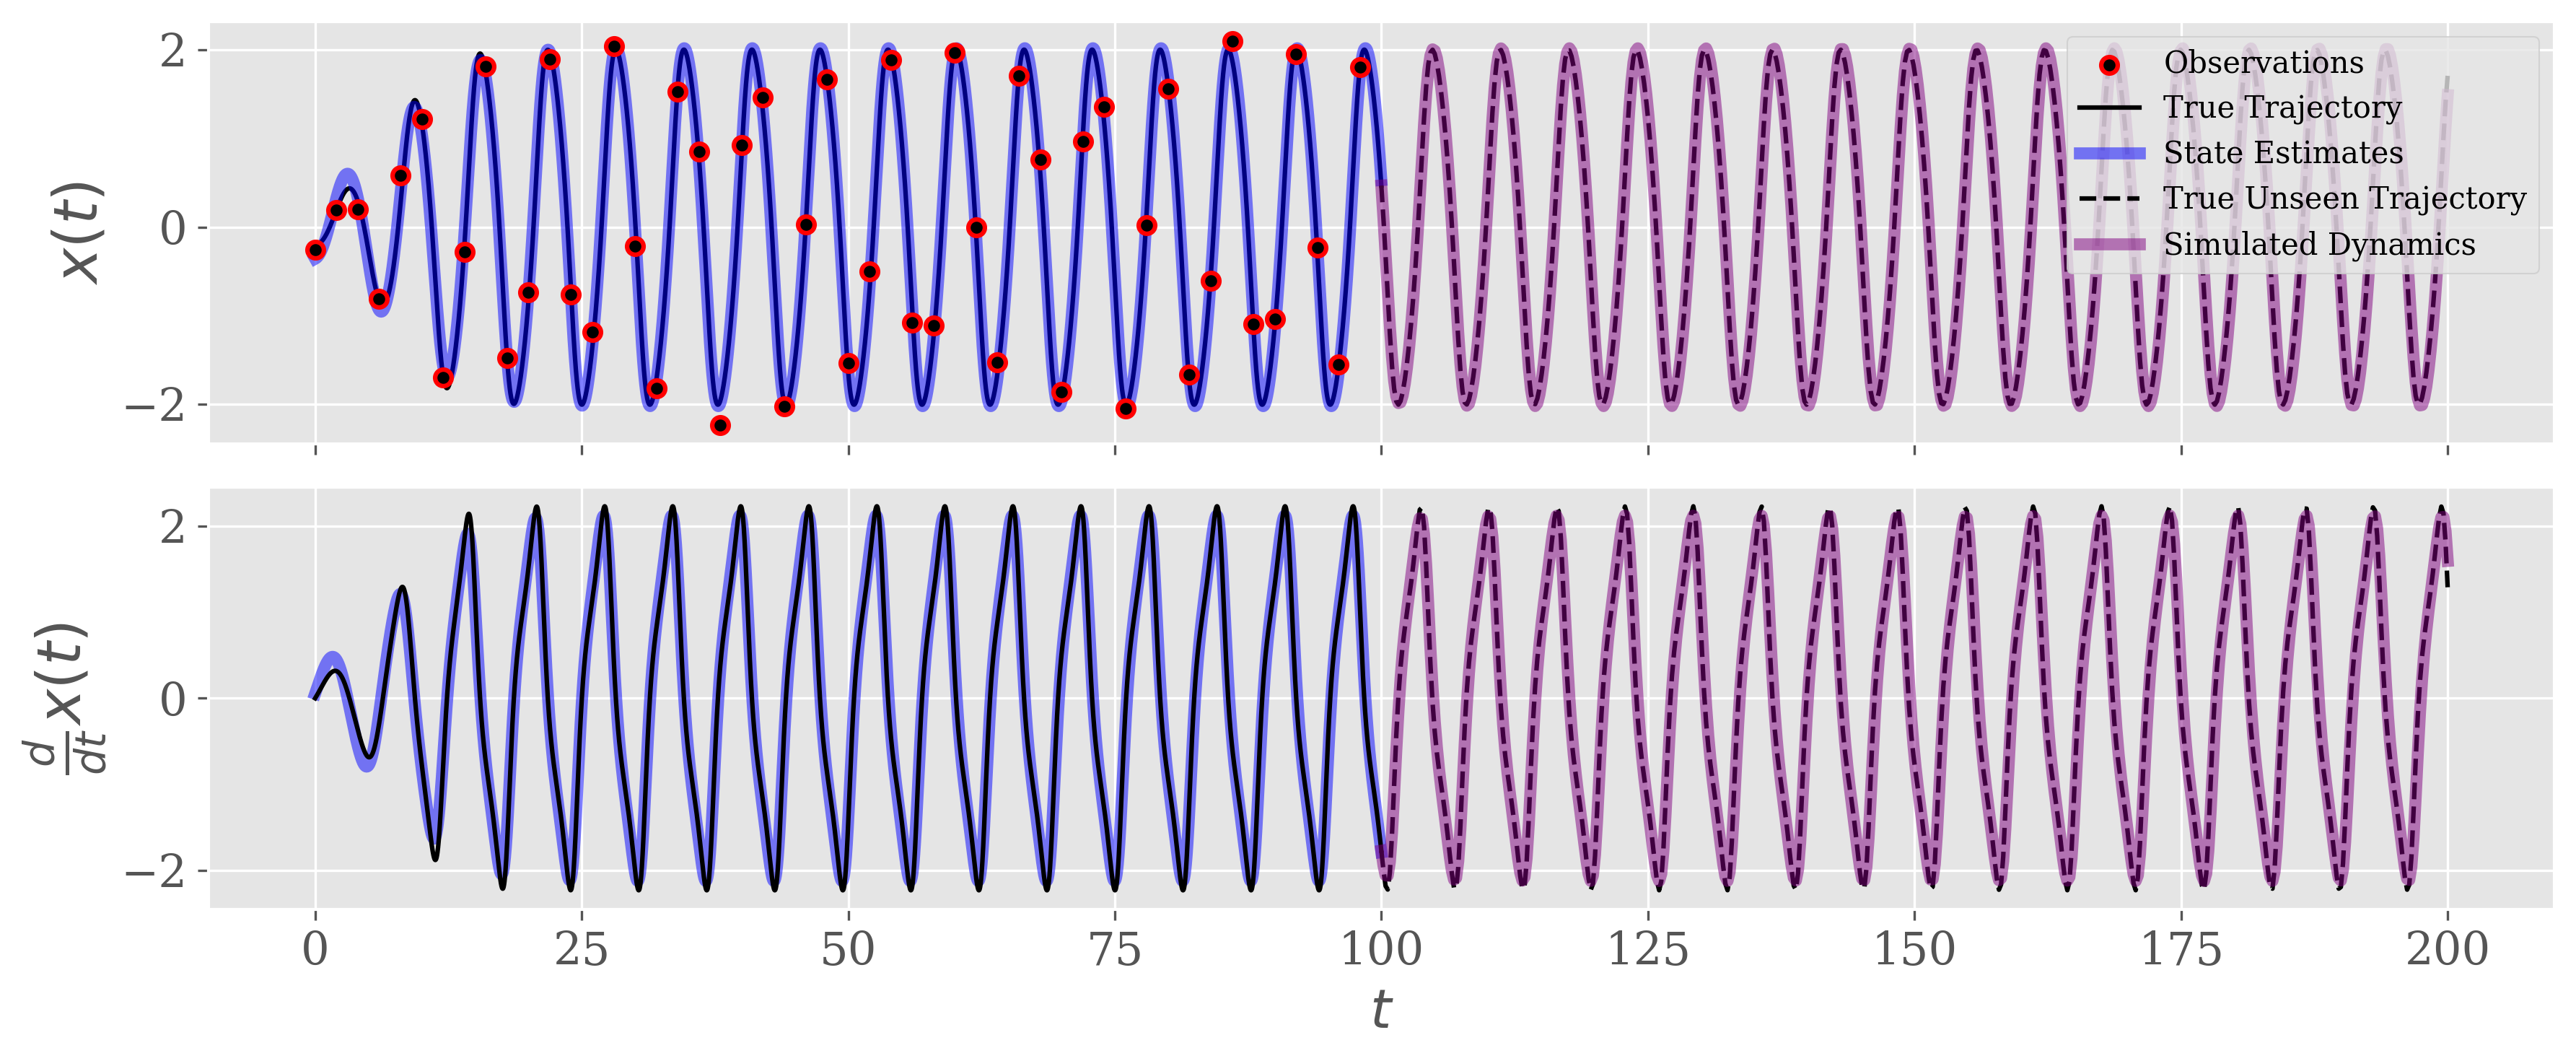

In [17]:


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,5),dpi=300,sharex=True)
ylabels = [r"$x(t)$", r"$\frac{d}{dt}x(t)$"]

ax1.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=30,lw=1.5)
ax1.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True Trajectory', c='black')
ax1.plot(t_true[:cutoff], x_pred[:cutoff], label="State Estimates", c='blue', alpha=0.5, lw=4)

ax1.plot(new_grid, true_forward,linestyle="--", c='black', label="True Unseen Trajectory")
ax1.plot(new_grid, learned_forward, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)
ax1.legend(loc='upper right')
ax1.set_ylabel(ylabels[0],size=20.0)

xdot_pred = model.traj_model.derivative(t_true,model.z)

ax2.plot(t_true, xdot_pred, c='blue', alpha=0.5, lw=4)
ax2.plot(t_true[:cutoff], X_true[:cutoff,1], label= 'True', c='black')

ax2.plot(new_grid, dx_true_forward,linestyle="--", c='black', )
ax2.plot(new_grid, dx_learned_forward, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)
ax2.set_ylabel(ylabels[1],size=20)
ax2.set_xlabel(r"$t$",size=18)



ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.savefig("vdp.pdf")
plt.show()


In [18]:
mse_state = jnp.mean((X_true[:,0] - x_pred.reshape(-1))**2,axis=0) / jnp.var(X_true[:,0],axis=0)
mse_deriv = jnp.mean((X_true[:,1] - xdot_pred.reshape(-1))**2,axis=0) / jnp.var(X_true[:,1],axis=0)

rmse_state = jnp.sqrt(mse_state)
# mse_state.item(), mse_deriv.item()

In [19]:
true_theta = jnp.array([0,-1,0.5,0,0,0,0,-0.5,0,0]).reshape(-1,1)
mae = jnp.linalg.norm(true_theta - model.theta) / jnp.linalg.norm(true_theta)
# mae = jnp.sum(jnp.abs(true_theta - model.theta))/jnp.sum(jnp.abs(true_theta))

In [20]:
mse_state.item(), rmse_state.item(), mae.item()

(0.0020613909097311352, 0.04540254298749284, 0.1857979280555529)

In [21]:
jnp.mean((X_true - x_pred)**2,axis=0), jnp.var(X_true,axis=0),jnp.mean((X_true - x_pred)**2,axis=0) / jnp.var(X_true,axis=0)

(Array([0.00377629, 3.66025996], dtype=float64),
 Array([1.83191331, 1.82383986], dtype=float64),
 Array([0.00206139, 2.00689766], dtype=float64))

# Phase portrait

In [22]:
n_points = 221
x_max = 5
x_min = -5

y_max = 5
y_min = -5
x_vals = np.linspace(x_min, x_max, n_points)
y_vals = np.linspace(y_min, y_max, n_points)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)
Uj = np.zeros(X0.shape)
Vj = np.zeros(Y0.shape)

# Evaluate the vector field
for i in tqdm(range(X0.shape[0])):
    for j in range(X0.shape[1]):
        arr = [X0[i, j], Y0[i, j]]
        dxdt, dydt = ode_sys(0, arr,args)
        U[i, j] = dxdt
        V[i, j] = dydt

        dxdt, dydt = arr[1], model.predict(jnp.array(arr))[0]
        Uj[i, j] = dxdt
        Vj[i, j] = dydt

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed


speed = np.sqrt(Uj**2 + Vj**2)
Uj /= speed
Vj /= speed

  0%|          | 0/221 [00:00<?, ?it/s]

/tmp/ipykernel_2560563/4207575008.py:30: RuntimeWarning: invalid value encountered in divide
  U /= speed
/tmp/ipykernel_2560563/4207575008.py:31: RuntimeWarning: invalid value encountered in divide
  V /= speed
/tmp/ipykernel_2560563/4207575008.py:35: RuntimeWarning: invalid value encountered in divide
  Uj /= speed
/tmp/ipykernel_2560563/4207575008.py:36: RuntimeWarning: invalid value encountered in divide
  Vj /= speed


In [23]:
initial_conditions = [
    jnp.array([3.,3.]),
    jnp.array([0.5,0.4]),
    jnp.array(([-4.,2.])),
    jnp.array([2.,-3.]),
    jnp.array([-4.,-3.]),
]

true_traj = []
sim_traj = []
for y0 in tqdm(initial_conditions):
    sol_continue = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args=args,
        saveat=diffrax.SaveAt(ts=t_true),
        max_steps = int(10*(t1-t0)/dt)
    )

    simulated_sol = diffrax.diffeqsolve(
        model_term,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args=args,
        saveat=diffrax.SaveAt(ts=t_true),
        max_steps = int(10*(t1-t0)/dt)
    )
    sim_traj.append(sol_continue.ys)
    true_traj.append(simulated_sol.ys)
    # sim_traj.append(jax.vmap(sol_continue.evaluate)(new_grid)[:,:])
    # true_traj.append(jax.vmap(simulated_sol.evaluate)(new_grid)[:,:])

  0%|          | 0/5 [00:00<?, ?it/s]

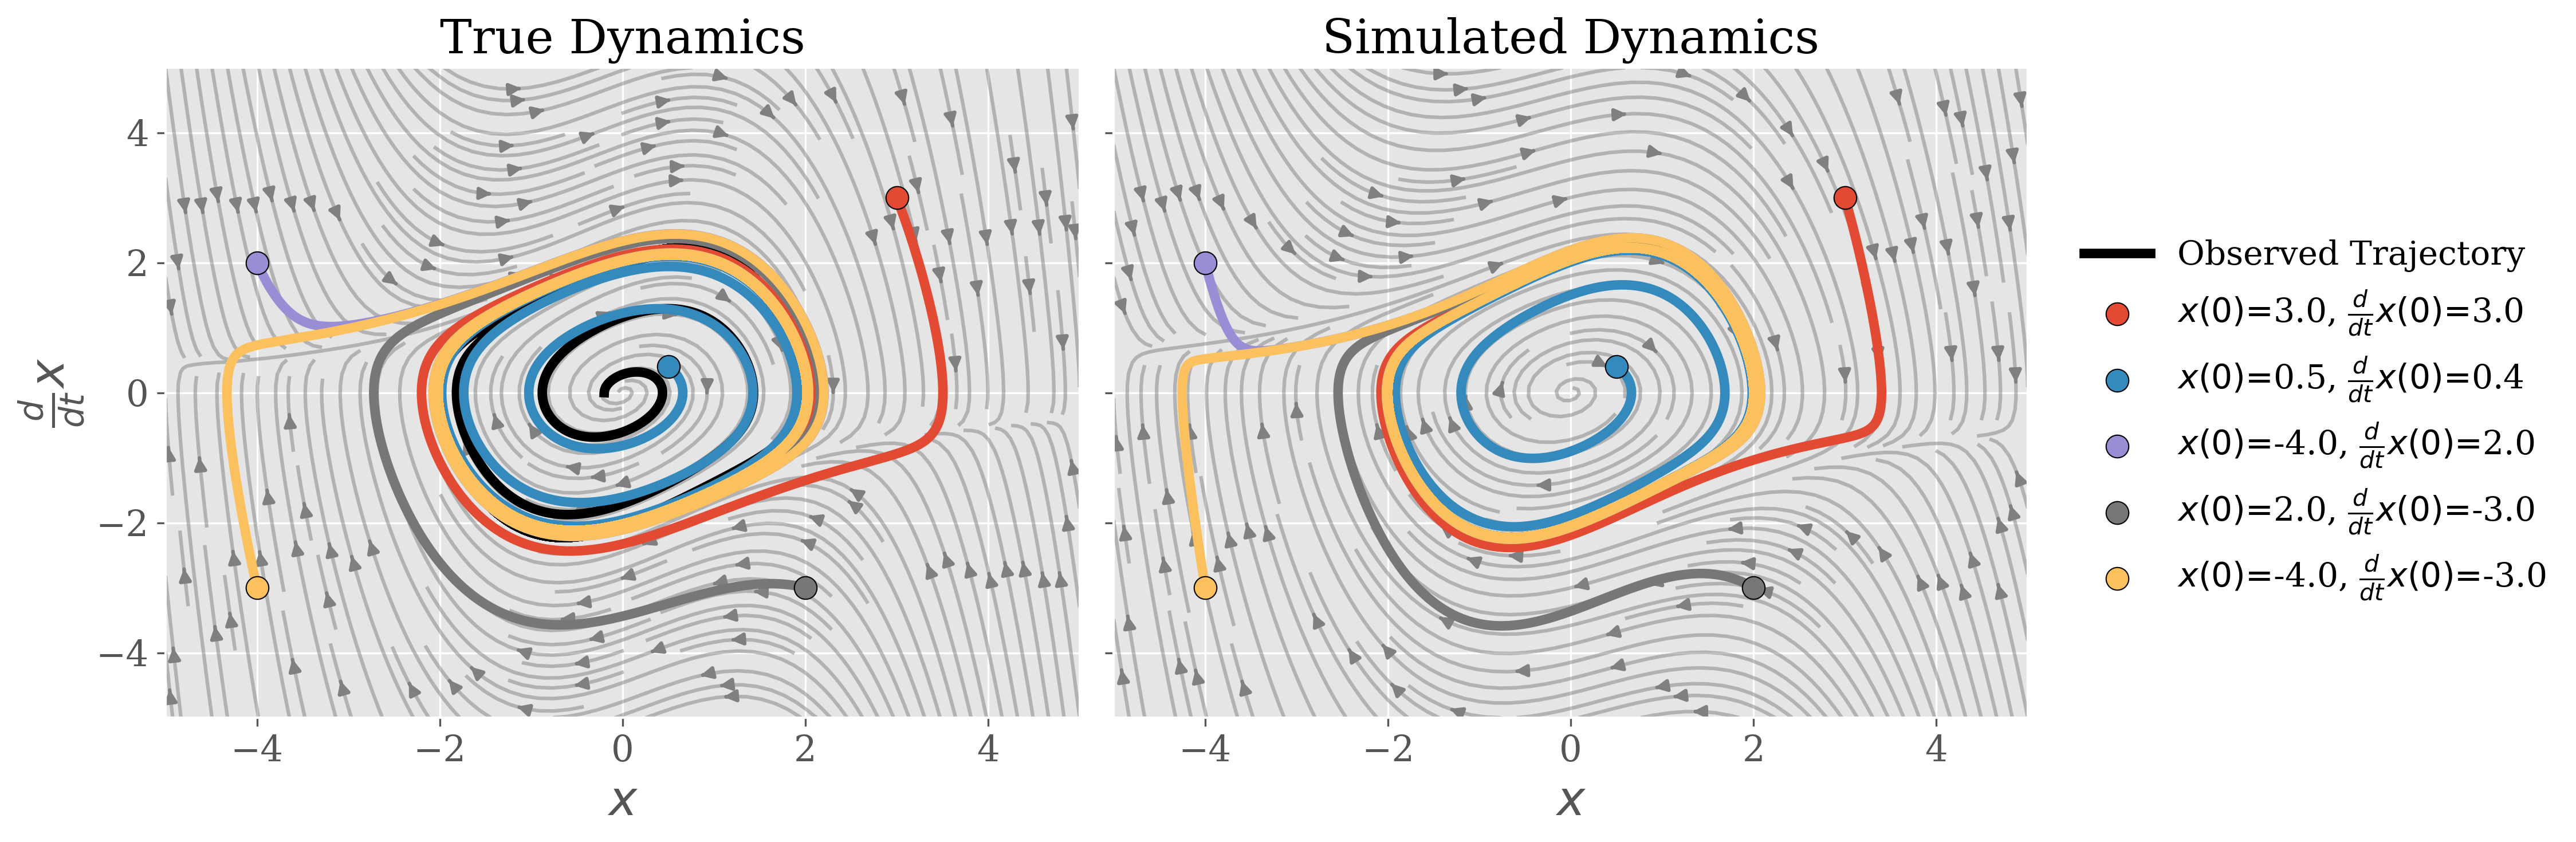

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True,dpi=300)
axs = axs.flatten()

sp0 = axs[0].streamplot(x_vals, y_vals, U, V, density=2, color='gray')
# axs[0].plot(x_true[:150, 0], x_true[:150, 1], **(TRUE_KW | {"lw": 4, "zorder": 4, "label": "True (observed)\nTrajectory"}))
axs[0].plot(X_true[:-1,0],X_true[:-1,1],linestyle='-', c='black',alpha=1,lw=4,label="Observed Trajectory",zorder=2)
axs[0].set_ylabel(r"$\frac{d}{dt} x$",size=20)
axs[0].set_xlabel(r"$x$",size=20)
axs[0].set_title("True Dynamics",family='serif',size=20)

# Change alpha for both lines and arrows
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

cutoff=-1
cutoffs = [1080, 1000,1150,1250,1050]
# cutoffs = np.array([80, 100,115,80,95])
sp1 = axs[1].streamplot(x_vals, y_vals, Uj, Vj, density=2, color='gray')


# Plot trajectories 
for idx, (x_true_i,x_pred_i) in enumerate(zip(true_traj,sim_traj)):

    cutoff = int(cutoffs[idx])
    cutoff = -1

    c=None
    ic = initial_conditions[idx]
    label = rf"$x(0)$={ic[0]}, " + r"$\frac{d}{dt} x(0)$="+f"{ic[1]}"
    axs[0].plot(x_true_i[:cutoff,0],x_true_i[:cutoff,1],
                lw=4,zorder=2,c=c,label=None)

    axs[1].plot(x_pred_i[:cutoff,0],x_pred_i[:cutoff,1],
                lw=4,zorder=2,c=c)
    axs[0].scatter(
        x_pred_i[0, 0], x_pred_i[0, 1],
        s=90, c=c, edgecolors='black', zorder=3, marker='o',label=None
    )

    obs_label2 = axs[1].scatter(
        x_pred_i[0, 0], x_pred_i[0, 1],
        s=90, c=c, edgecolors='black', zorder=3, marker='o',label=label
    )
    arr_bump=0
    # add_arrow_at_end(axs[1],x_pred_i[:cutoff+arr_bump, 0], x_pred_i[:cutoff+arr_bump, 1],color=c,mutation_scale=30)

axs[1].set_xlabel(r"$x$",size=20)
axs[1].set_title("Simulated Dynamics", family='serif',size=20)

axs[0].set_xlim(x_min,x_max)
axs[1].set_xlim(x_min,x_max)

axs[0].set_ylim(y_min,y_max)
axs[1].set_ylim(y_min,y_max)

axs[0].tick_params(axis='both', labelsize=15)
axs[1].tick_params(axis='both', labelsize=15)


n_start = 0
n_end = -1
skip = 5

# x_train_plot = x_train[n_start:n_end:skip]

# axs[0].scatter(
#     x_train_plot[:,0],
#     [y_min+0.05]*len(x_train_plot), 
#     zorder=3, 
#     facecolors='black', 
#     edgecolors='red',
#     marker='.', 
#     s=250, 
#     lw=3, 
#     label="Observations",
#     clip_on = False
# )
# for (xi, xdot_i) in x_train_plot:
#     axs[0].vlines(xi,ymin=y_min, ymax = xdot_i,linestyle='--',lw=2,alpha=0.8, color='black',zorder=1)



# Change alpha for both lines and arrows
sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)


fig.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    frameon=False,
    fontsize=14,
)

plt.tight_layout()

# plt.savefig("vdp_true_phase.pdf", bbox_inches="tight")

In [25]:
for true_i, sim_i in zip(true_traj, sim_traj):
    out = jnp.mean((true_i - sim_i)**2, axis=0) / jnp.var(true_i,axis=0)
    print(out)

[0.11675607 0.14356681]
[0.02497109 0.03466203]
[0.6836923  0.77188274]
[0.0018263 0.0047748]
[0.59458425 0.744359  ]
